Use spikeinterface to simplify the spike sorting pipeline for dots3DMP
For single electrode recordings, use wave_clus.
For probe recordings, compare Kilosort (multiple versions) to each other, and a few other sorters, to settle on preferred one?
Using Kilosort 2.0 via Matlab, but I'm unconvinced or uncertain about a lot of the output.

For guidance and example code, much of which was adapted for this notebook, see:
https://spikeinterface.readthedocs.io/en/latest/overview.html
https://probeinterface.readthedocs.io/en/main/index.html

Steven Jerjian Created 01/2023

In [2]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
from spikeinterface.qualitymetrics import (compute_snrs, compute_firing_rate,
    compute_isi_violations, calculate_pc_metrics, compute_quality_metrics)
from spikeinterface.exporters import export_to_phy

from probeinterface import Probe
from probeinterface.plotting import plot_probe

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# if sorter is not installed, no problem, just use the docker image.
print('Available sorters', ss.available_sorters())
#print('Installed sorters', ss.installed_sorters())


Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'pykilosort', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']


Provide subject, and date(s) we want to sort
Provide probe_type as 'single', 'DBC32-A' etc
Find all ns5 files for that date, for sorting

Define recording 'sets', i.e. the grouping of ns5 files that were recorded at the same depth (and should be sorted together).
Should be incremental e.g. [1 2 3 4 5], or [1 1 2 2]. Sets are specified in recording notes and Matlab _info file

In [4]:
# for now it's easier to stick to sorting just one recording at a time. We will need to inspect the results of each one anyway
# but we could make rec_set (and ns5_files) a list of lists

subject = 'lucio'
date    = 20220218

probe_type = 'single'
distance_to_first_contact = 750 # only relevant for DBC probes, this is estimate based on microscope inspection, and probe specific

#data_dir = r'\\172.30.3.33\\homes\\fetschlab\\data\\{0}\\{0}_neuro\\{1}\\'.format(subject,str(date))
#data_dir = 'Z:/{0}/{0}_neuro/{1}/'.format(subject,str(date))
data_dir = 'D:/{}/'.format(str(date))
#data_dir = '/mnt/z/fetschlab/data/{0}/{0}_neuro/{1}/'.format(subject,str(date))
print(data_dir)

D:/20220218/


In [5]:
ns5_files = glob.glob(data_dir + '*.ns5')
#ns5_files = [f.replace('\\','/') for f in ns5_files]

# get the recording "set" for each file, and the files we actually want (remove files marked for ignore)
from mat4py import loadmat
info = loadmat("{}{}{}dots3DMP_info.mat".format(data_dir,subject,date))

rec_set = np.array([info['info']['rec_group']]).T
ignores = np.isnan(np.array([info['info']['pldaps_filetimes']])).T

_, ufi  = np.unique(info['info']['trellis_filenums'], return_index=True)

if type(rec_set) is int:
    rec_set = [rec_set]
    
rec_set = rec_set[ufi]

rec_set_all = rec_set
ns5_files_all = ns5_files

if np.any(ignores):
   
    rec_set = []
    ns5_files = []

    for i,r in enumerate(rec_set_all):
        if ~ignores[i]:
            rec_set.append(r)
            ns5_files.append(ns5_files_all[i])

print("Directory: " + data_dir)
for i, r in enumerate(rec_set_all):
    print(i, r, ignores[i], rec_set_all[i], ns5_files_all[i])
print("\nTotal number of files = " + str(len(ns5_files)))


Directory: D:/20220218/
0 [1] [False] [1] D:/20220218\lucio20220218dots3DMP0001.ns5
1 [2] [ True] [2] D:/20220218\lucio20220218dots3DMP0002.ns5

Total number of files = 1


Define probe geometry. Single electrode seems unnecessary, but waveform_extractor seems to need it

In [6]:
show_probe = False

if probe_type == 'single':
    n=1
    positions = np.zeros((1,2))
    channel_indices = [1]
elif probe_type == 'DBC32-A':
    n = 32
    positions = np.zeros((n, 2))
    positions[:,1] = np.arange(n)*65 + distance_to_first_contact
    channel_indices = [4,  30,  5, 27,  6, 28,  7, 25, 
                       3,  29,  8, 26,  9, 23, 10, 24,  
                       2,  32, 11, 21, 12, 22, 13, 19, 
                       16, 18,  1, 31, 14, 20, 15, 17]

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=positions, shapes='circle', shape_params={'radius': 10})
probe.set_contact_ids(range(n))

probe.set_device_channel_indices([c-1 for c in channel_indices])
probe.create_auto_shape(probe_type='tip')

if show_probe:
    print(probe)
    fig, ax = plt.subplots(figsize= (5,15))
    plot_probe(probe, ax = ax, with_contact_id=False, with_device_index=True)

In [7]:
# print('Default parameters')
# print('\nWaveClus')
# print(ss.get_default_sorter_params('waveclus'))
# print('\nKilosort2')
# print(ss.get_default_sorter_params('kilosort2'))
# print('\nMountainSort')
# print(ss.get_default_sorter_params('mountainsort4'))
#print('\nHDSort')
#print(ss.get_default_sorter_params('hdsort'))

#si.set_global_tmp_folder('C:/Users/fetschlab/Trellis/dataFiles/')
#si.get_global_tmp_folder()

ss.WaveClusSorter.set_waveclus_path('C:/Users/fetschlab/Documents/MATLAB/wave_clus-master')
#ss.Kilosort2Sorter.set_kilosort2_path('C:/Users/fetschlab/Documents/MATLAB/Kilosort-2.0')
#ss.HDSortSorter.set_hdsort_path('C:/Users/fetschlab/Documents/MATLAB/HDsort')
#ss.IronClustSorter.set_ironclust_path('C:/Users/fetschlab/Documents/MATLAB/ironclust')

sorter_list = ['kilosort2','hdsort','ironclust']

Setting WAVECLUS_PATH environment variable for subprocess calls to: C:\Users\fetschlab\Documents\MATLAB\wave_clus-master


In [8]:
usets = np.unique(rec_set)
filenums = list(range(len(rec_set)))

# TEMP for testing
#usets = [1]
#filenums = [0]

fs = 30000

# sort each 'set' (set is a python keyword, don't use it!)
for s in usets:

    print('Set {}:\n'.format(s))
    # find associated binary file
    binfolder = '{}{}_{}'.format(subject, str(date), str(s))
    #outfolder = 'C:/Users/fetschlab/Trellis/dataFiles/{}_si'.format(binfolder)
    outfolder = '{}{}'.format(data_dir, binfolder)
    
    sort_folder = outfolder + '/sorting_output'

    if probe != 'single':
        bin_filepath = '{0}{1}/{1}.bin'.format(data_dir,binfolder)
    
    ind_files = [filenums[f] for f in filenums if s==rec_set[f]]
    print(ind_files)
    
    if not(len(ind_files)): 
        continue
        
    # append files from same set, if needed, to sort them together
    recordings_list = []
    for file in ind_files:

        if probe_type == 'single':
            this_filepath = ns5_files[file]
            recording = se.read_blackrock(this_filepath,stream_id='5') 
        else:
            recording = si.read_binary(bin_filepath,sampling_frequency=fs,num_chan=n, dtype='int16',time_axis=1)
                
        recording = recording.set_probe(probe)
        
        # bandpass filter for spikes
        # I don't think this is necessary if it's done in sorter? i think there is a setting in sorting. for now do it here
        recording = spre.bandpass_filter(recording, freq_min=300, freq_max=6000)
        
        # common average referencing. also seems like this is default for kilosort
        #recording = spre.common_reference(recording, reference='global', operator='median')
        
        recordings_list.append(recording)
        
    # put the recordings together, so that we can track unit IDs across grouped recs 
    multirecording = si.concatenate_recordings(recordings_list)
    multirecording = multirecording.set_probe(recording.get_probe()) # add a probe geometry, I guess it is not auto-inherited
    print(multirecording)
    
    
    # container needs to be able to access recording on disk
    if probe_type == 'single':
        
        try:
            multirecording = multirecording.save(format='binary', folder=outfolder, verbose=True)
        except:
            print("Recording folder already exists...?")
            
        sorting_WC  = ss.run_waveclus(recording=multirecording, docker_image=False)
        print('Units found by waveClus:', sorting_WC.get_unit_ids())
        
        waveforms_folder = outfolder + '/waveforms_WC'

        # get all waveforms
        we_WC = si.extract_waveforms(
                      multirecording, 
                      sorting_WC, 
                      waveforms_folder,
                      load_if_exists=True,
                      ms_before=1, ms_after=2., max_spikes_per_unit=None,
                      n_jobs=1, chunk_size=30000,
                      return_scaled=True,
                      with_recording=False)
        
        # now that we have the waveforms, export to phy for visualization and curation
        export_to_phy(we_WC, outfolder + '/phy_WC',
             compute_pc_features=True, compute_amplitudes=True)
        
    else:
        
        # need to test this
        #sorting_output = si.sorters.run_sorters(sorter_list, multirecording, working_folder=outfolder, sorter_params={}, 
        #                                   mode_if_folder_exists='keep', with_output=True)
        
        # at some point switch to ss.sorters, to run multiple in one call. with dicts for inputs 
        
        try:
        # although we have the binary file already, I think we need this for the json files 
            multirecording = multirecording.save(format='binary', folder=outfolder, verbose=True, chunk_size=fs*2)
        except:
            print("Recording folder already exists...?")
                    
        #sorting_HDS  = ss.run_hdsort(recording=multirecording, output_folder=sort_folder, docker_image=False, chunk_size=fs*5,
        #                            remove_existing_folder=True, delete_output_folder=False)
        sorting_KS2 = ss.run_kilosort2(recording=multirecording, docker_image=True, chunk_size=fs*5,
                                    delete_output_folder=True)
        #sorting_IC = ss.run_ironclust(recording=multirecording, docker_image=True, chunk_size=fs*5,
        #                            delete_output_folder=True)

#         waveforms_folder = outfolder + '/waveforms_HDS'

#         we_HDS = si.extract_waveforms(
#                      multirecording, 
#                      sorting_HDS, 
#                      waveforms_folder,
#                      load_if_exists=True,
#                      ms_before=1, ms_after=2., max_spikes_per_unit=None,
#                      n_jobs=1, chunk_size=fs*4,
#                       return_scaled=True)
        
#         export_to_phy(we_HDS, outfolder + '/phy_HDS',
#                compute_pc_features=True, compute_amplitudes=True)
            
        
        waveforms_folder = outfolder + '/waveforms_KS2'
        we_KS = si.extract_waveforms(
                     multirecording, 
                     sorting_KS2, 
                      waveforms_folder,
                      load_if_exists=True,
                      ms_before=1, ms_after=2., max_spikes_per_unit=None,
                      n_jobs=1, chunk_size=fs*4,
                      return_scaled=True)

        export_to_phy(we_KS, outfolder + '/phy_KS',
              compute_pc_features=True, compute_amplitudes=True)
        
        
        waveforms_folder = outfolder + '/waveforms_IC'
        we_IC = si.extract_waveforms(
                     multirecording, 
                     sorting_IC, 
                      waveforms_folder,
                      load_if_exists=True,
                      ms_before=1, ms_after=2., max_spikes_per_unit=None,
                      n_jobs=1, chunk_size=fs*4,
                      return_scaled=True)

        export_to_phy(we_KS, outfolder + '/phy_IC',
              compute_pc_features=True, compute_amplitudes=True)
        
        

        # Compare the sorter outputs

#         comp_KS_HDS = sc.compare_two_sorters(sorting1=sorting_KS2, sorting2=sorting_HDS)
#         comp_KS_HDS.hungarian_match_12 
        

Set 1:

[0]
ConcatenateSegmentRecording: 1 channels - 1 segments - 30.0kHz - 1120.566s
write_binary_recording with n_jobs = 1 and chunk_size = None
RUNNING SHELL SCRIPT: C:\Users\FETSCH~1\AppData\Local\Temp\tmp_shellscript9utoot4e\script.bat
RUNNING SHELL SCRIPT: C:\Users\FETSCH~1\AppData\Local\Temp\tmp_shellscript2fohcsqo\script.bat
RUNNING SHELL SCRIPT: C:\Users\FETSCH~1\AppData\Local\Temp\tmp_shellscriptzu193rco\script.bat
RUNNING SHELL SCRIPT: C:\Users\fetschlab\Desktop\waveclus_output\run_waveclus.bat
Traceback (most recent call last):
  File "C:\Users\fetschlab\AppData\Local\Programs\Python\Python310\lib\site-packages\spikeinterface\sorters\basesorter.py", line 225, in run_from_folder
    SorterClass._run_from_folder(output_folder, sorter_params, verbose)
  File "C:\Users\fetschlab\AppData\Local\Programs\Python\Python310\lib\site-packages\spikeinterface\sorters\waveclus\waveclus.py", line 213, in _run_from_folder
    raise Exception('waveclus returned a non-zero exit code')
Excep

SpikeSortingError: Spike sorting failed. You can inspect the runtime trace in waveclus_output/spikeinterface_log.json

In [ ]:
filenums = list(range(len(rec_set)))
filenums

In [ ]:
print(multirecording.get_num_channels())
print(outfolder)
#export_to_phy(we_WC, './phy_WC',
#               compute_pc_features=False, compute_amplitudes=True)

Channel ids: ['3']
Sampling frequency: 30000.0
Number of channels: 1
Number of segments: 1
BandpassFilterRecording: 1 channels - 1 segments - 30.0kHz - 547.518s


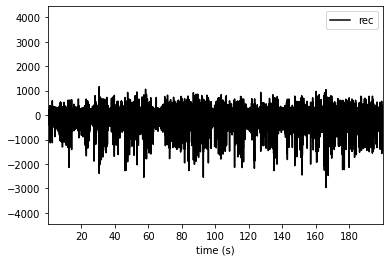

In [16]:
# some basic metadata diagnostics

channel_ids = multirecording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(recording)
w_ts = sw.plot_timeseries(recording, time_range=(0, 200))

In [ ]:
# print the dimensions of waveforms and template vars, and plot preview of rasters

unit_id0 = sorting_WC.unit_ids[0]
waveforms = we_WC.get_waveforms(unit_id0)
print(waveforms.shape)

template = we_WC.get_template(unit_id0)
print(template.shape)

w_rs = sw.plot_rasters(sorting_WC, time_range=(0, 100))

In [ ]:
# plot waveforms and mean templates

colors = ['Olive', 'Teal', 'Fuchsia']

fig, ax = plt.subplots(2,1)
for i, unit_id in enumerate(sorting_WC.unit_ids[:3]):
    wf = we_WC.get_waveforms(unit_id)
    ax[0].plot(wf[:200, :, 0].T, color=colors[i], lw=0.25) 
    
    template = we_WC.get_template(unit_id)
    ax[1].plot(template[:, 0].T, color=colors[i], lw=3)    
plt.show()

In [ ]:
# gui for viewing sorting output (no curation, Phy is needed for that)

import spikeinterface_gui
# This creates a Qt app
app = spikeinterface_gui.mkQApp() 
# reload the waveform folder
we = si.WaveformExtractor.load_from_folder(wavefl\)
# create the mainwindow and show
win = spikeinterface_gui.MainWindow(we)
win.show()
# run the main Qt6 loop
app.exec()